In [3]:
#Set google drive
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Install miniconda and rdkit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [11]:
#Read smiles files
with open('/content/gdrive/My Drive/Colab Notebooks/smiles.txt') as f:
  smiles = f.readlines()[:5000]
  smiles = [s.strip() for s in smiles]
  smiles = [s.split()[1] for s in smiles]
print (len(smiles))
print (smiles)

5000
['O=[N+]([O-])c1ccc(O)c(/C=N/c2ccc3nccnc3c2)c1', 'CCOC(=O)C1CCCNC1=O', 'C/C(=N/O)C1=CC(C)(C)CCC1', 'Cc1cc(N/N=C/c2cccc([N+](=O)[O-])c2)nc(-n2nc(C)cc2C)n1', 'CCOc1ccc(C2NC(=O)NC(C)=C2C(=O)OCc2ccccc2)cc1', 'CC(/C=C/c1ccc2c3c(cccc13)CC2)=C\\C(=O)[O-].[Na+]', 'CC1(C)Cc2ccccc2/C(=C/C(=O)Nc2ccccc2[N+](=O)[O-])N1', 'Cc1cc(C)c(NC(=O)/C=C2\\NC(C)(C)Cc3ccccc32)c(C)c1.Cl', 'Cn1c(=O)c(C(=O)Nc2ccncc2)c(O)c2ccccc21', 'Cc1cc(O)nc(N2CCCCC2)n1', 'C(#Cc1ccccc1)CN1CCCCC1.Cl', 'O=C1NC(=O)C(=Cc2cn(-c3ccccc3)nc2-c2ccccc2)C(=O)N1', 'C=Cc1cc2ccccc2c2cc3c(cc12)C[N+](C)(C)C3.[Br-]', 'CCCCOc1ccc(C(CC(=O)O)C(=O)O)cc1', 'Cc1ccc(-c2cn3c4ccc5ccccc5c4nc3n2-c2ccc(C)cc2)cc1', 'CC(CC1OCC(C[N+]2(C)CCCCC2)O1)CC(C)(C)C.[I-]', 'CCOC(=O)C(Cc1ccc(OC)c([N+](=O)[O-])c1)NC(=O)CCC(=O)Nc1cccc([N+](=O)[O-])c1', 'O=C(OCc1ccccc1)Oc1cncc(C(=O)ON2C(=O)CCC2=O)c1', 'Cl.c1coc(CNCC2OCCc3ccccc32)c1', 'COCCOC(=O)c1c(C)oc2ccc(OC(=O)C(C)(C)C)cc12', 'CCCCn1nc(CC(=O)NCCN(CC)CC)c2ccccc2c1=O', 'C=CCN1C(=O)NC(=O)/C(=C/c2ccc(O)cc2)C1=O', 'CN1C(

In [13]:
#Calculate Morgan fingerprints and LogP of each molecule
from rdkit import Chem
from rdkit.Chem.Crippen import MolLogP
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np
import torch

X, Y = [], []
for s in smiles:
  print (s)
  m = Chem.MolFromSmiles(s)
  print (m)
  fp = np.array(AllChem.GetMorganFingerprintAsBitVect(m,2, nBits=1024))
  print (fp)
  print (np.shape(fp))
  logp = MolLogP(m)
  X.append(fp)
  Y.append(logp)
  break
  
#Convert to torch tensor
X = torch.from_numpy(np.array(X)).float()
Y = torch.from_numpy(np.array(Y)).float()

print (X.size())
print (Y.size())

O=[N+]([O-])c1ccc(O)c(/C=N/c2ccc3nccnc3c2)c1
[0 0 0 ... 0 0 0]
(1024,)
torch.Size([1, 1024])
torch.Size([1])


In [7]:
#Divide training and test data
num_train = 4000
X_train = X[:num_train]
Y_train = Y[:num_train]
X_test = X[num_train:]
Y_test = Y[num_train:]

print (f'Num train data: {len(X_train)}')
print (f'Num test data: {len(X_test)}')


Num train data: 4000
Num test data: 1000


In [0]:
import torch
import torch.nn as nn

class LinearRegressor(torch.nn.Module):
  def __init__(self, D_in, D_out):
    super(LinearRegressor, self).__init__()
    self.linear = torch.nn.Linear(D_in, D_out)

  def forward(self, x):
    retval = self.linear(x)
    return retval

In [9]:
#Train model
import time
lr = 1e-4
model = LinearRegressor(1024,1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
loss_list = []
st = time.time()

X_train = X_train.cuda()
Y_train = Y_train.cuda()
model = model.cuda()

for i in range(5001):
  pred = model(X_train)
  pred = pred.squeeze(-1)
  loss = loss_fn(pred, Y_train)
  loss.backward()
  optimizer.step()
  loss_list.append(loss.data.cpu().numpy())
  if i%1000==0:
    print (i, loss.data.cpu().numpy())
end = time.time()
print ('Time:', end-st)

0 11.186823
1000 5.1219025
2000 2.6214342
3000 1.9917613
4000 1.9358814
5000 2.0971472
Time: 10.661142587661743


Text(0, 0.5, 'Loss')

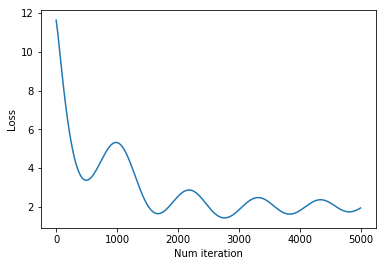

In [38]:
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.xlabel('Num iteration')
plt.ylabel('Loss')


In [39]:
#Test model
y_pred_train = model(X_train).squeeze(-1)
y_pred_test = model(X_test).squeeze(-1)

loss_train = loss_fn(Y_train, y_pred_train)
loss_test = loss_fn(Y_test, y_pred_test)

print ('Train loss:', loss_train.data.cpu().numpy())
print ('Test loss:', loss_test.data.cpu().numpy())

Train loss: 1.9460124
Test loss: 2.3043926


Text(0, 0.5, 'Pred')

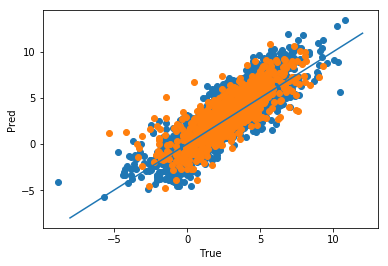

In [40]:

plt.scatter(Y_train, y_pred_train.data.cpu().numpy())
plt.scatter(Y_test, y_pred_test.data.cpu().numpy())
plt.plot([-8,12], [-8,12])
plt.xlabel('True')
plt.ylabel('Pred')
